In [4]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

In [6]:
env = gym.make("CartPole-v1", max_episode_steps=200, render_mode="rgb_array")

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n


In [7]:
class QNetwork(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(QNetwork, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

### 经验池

In [8]:
class ReplayBuffer:
    def __init__(self, max_size: int, obs_dim: int, batch_size: int = 32):
        self._obs_buf = np.zeros([max_size, obs_dim], dtype=np.float32)
        self._act_buf = np.zeros([max_size], dtype=np.float32)
        self._reward = np.zeros([max_size], dtype=np.float32)
        self._next_obs_buf = np.zeros([max_size, obs_dim], dtype=np.float32)
        self._done = np.zeros([max_size], dtype=np.float32)
        
        self._index = 0
        self._size = 0
        self._max_size = max_size
        self._batch_size = batch_size
        
    def store(self, obs: np.ndarray, act: np.ndarray, rew: float, next_obs: np.ndarray, done: bool):
        self._obs_buf[self._index] = obs
        self._act_buf[self._index] = act
        self._reward[self._index] = rew
        self._next_obs_buf[self._index] = next_obs
        self._done[self._index] = done
        self._index = (self._index + 1) % self._max_size
        self._size = min(self._size + 1, self._max_size)
        
    def __len__(self) -> int:
        return self._size
    
    def sample(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self._size, size=self._batch_size, replace=False)
        return dict(obs=self._obs_buf[idxs],
                    acts=self._act_buf[idxs],
                    rews=self._reward[idxs],
                    next_obs=self._next_obs_buf[idxs],
                    done=self._done[idxs])

In [9]:
epsilon = 0.2
def select_action(state, explore = True):
    # 选择动作，有0.2的概率进行随机探索
    if explore and np.random.random() < epsilon:
        return env.action_space.sample()
    
    # 有0.8的概率从当前训练的Q函数中，预测所有可能动作的Q值
    q_value = Q(torch.FloatTensor(state).to(device))
    action = q_value.argmax().detach().cpu().item()
    return action

In [10]:
Q = QNetwork(obs_dim, action_dim).to(device)
#
optimizer = optim.Adam(Q.parameters(), lr=0.001)

In [26]:
t = torch.LongTensor([[1,2],[3,4]])
print(t)
i = torch.LongTensor([0,1]).reshape(-1, 1)
print(i)
t.gather(1, i)

tensor([[1, 2],
        [3, 4]])
tensor([[0],
        [1]])


tensor([[1],
        [4]])

In [27]:
gamma = 0.98
seed = 3
max_buffer = 2000
buffer = ReplayBuffer(max_buffer, obs_dim)

scores = []
losses = []
steps = []
#在不用经验池的时候,5000次也能训练出来,我们降低训练次数,希望能很快学到策略
epoch = 1000
while True:
    if epoch <= 0:
        break
    
    epoch -= 1
    score = 0
    '''使用如下方式时，state的类型是list，否则是一个array'''
    state, _ = env.reset()
    
    step = 0
    while True:
        '''这里代理选择一个动作来执行'''
        action = select_action(state)
        '''得到下一个状态,构成(s,a,r,s')'''
        next_state, reward, done, truncated, _ = env.step(action)
        
        buffer.store(state, action, reward, next_state, done)
        score += reward
        step += 1
        
        '''采集完毕，开始训练'''
        if len(buffer) >= max_buffer:
            samples = buffer.sample()
            states = torch.FloatTensor(samples['obs']).to(device)
            actions = torch.LongTensor(samples['acts']).reshape(-1, 1).to(device)
            rewards = torch.FloatTensor(samples['rews']).reshape(-1, 1).to(device)
            next_states = torch.FloatTensor(samples['next_obs']).to(device)
            dones = torch.LongTensor(samples['done']).reshape(-1, 1).to(device)
            q = Q(torch.FloatTensor(states).to(device))
            q_value = q.gather(1, actions)

            next_q_value = Q(torch.FloatTensor(next_states).to(device)).max().reshape(1)
            mask = 1 - dones
            target = reward + gamma * next_q_value * mask

    #         print(q_value, target, q_value.shape, target.shape)
            loss = F.smooth_l1_loss(q_value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if epsilon < 0.05:
                epsilon = 0.05
            else:
                epsilon *= 0.98

        
        if done or step >= 200:
            scores.append(score)
            steps.append(step)
            break
            
        state = next_state


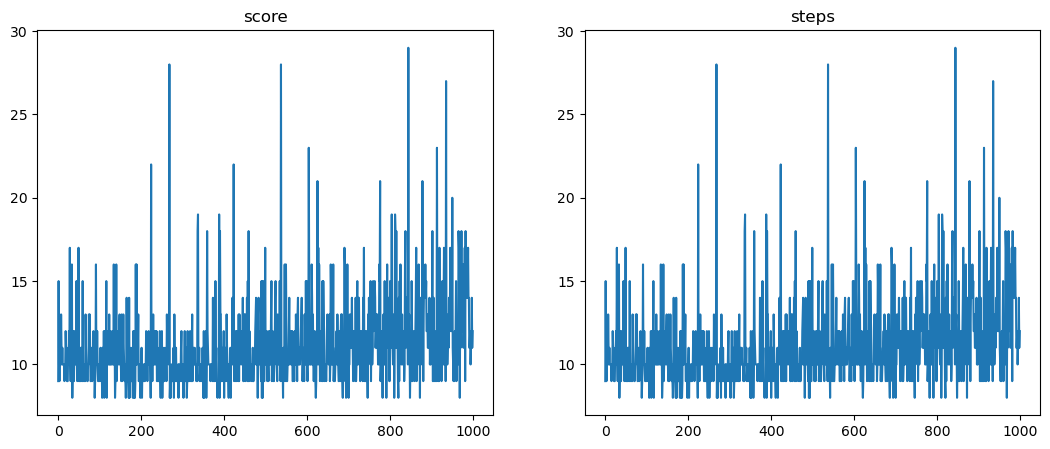

In [28]:
# 观察曲线
plt.figure(figsize=(20, 5))
plt.subplot(131)
# plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
plt.title('score')
plt.plot(scores)
plt.subplot(132)
plt.title('steps')
plt.plot(steps)
# plt.subplot(133)
# plt.title('epsilons')
# plt.plot(epsilons)
plt.show()

In [29]:
# 观察效果
def test():
    dvideo_env = gym.wrappers.RecordVideo(env, video_folder='.')
    state, _ = dvideo_env.reset(seed=seed)
    done = False
    score = 0
    step = 0
    while not done and step < 200:
        action = select_action(state, False)
        next_state, reward, done, truncated, _ = dvideo_env.step(action)

        state = next_state
        score += reward
        step +=1

    print("score: ", score, "step:", step)
    dvideo_env.close()
    
test()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/webberg/workspace/code/reinforce_learning/rainbow folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/webberg/workspace/code/reinforce_learning/rainbow/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/webberg/workspace/code/reinforce_learning/rainbow/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/webberg/workspace/code/reinforce_learning/rainbow/rl-video-episode-0.mp4
score:  9.0 step: 9


### 优先经验池

In [ ]:
class PriorReplayBuffer:
    def __init__(self):
        pass